<a href="https://colab.research.google.com/github/kennethjiang/3DPrintSaviour/blob/master/Anomaly_Detection_Nezih.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

from glob import glob
glob("/content/drive/MyDrive/timelapses/*", recursive = False)

Mounted at /content/drive


['/content/drive/MyDrive/timelapses/DASH_480.mp4',
 '/content/drive/MyDrive/timelapses/DASH_720-3.mp4',
 '/content/drive/MyDrive/timelapses/DASH_720-4.mp4',
 '/content/drive/MyDrive/timelapses/DASH_720-5.mp4',
 '/content/drive/MyDrive/timelapses/DASH_480-2.mp4',
 '/content/drive/MyDrive/timelapses/DASH_720-7.mp4',
 '/content/drive/MyDrive/timelapses/multi_material_test_2_0.15mm_PLA_MK3SMMU2S_5h16m_20220322043743.mp4',
 '/content/drive/MyDrive/timelapses/Merged_0.15mm_PLA_MK3SMMU2S_1h8m_20220324025925.mp4',
 '/content/drive/MyDrive/timelapses/Lever_0.15mm_PLA_MK3SMMU2S_5h26m_20220501013518.mp4',
 '/content/drive/MyDrive/timelapses/FAILED_newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220502124240.mp4',
 '/content/drive/MyDrive/timelapses/FAILED_newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220503163150.mp4',
 '/content/drive/MyDrive/timelapses/newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220509072520.mp4',
 '/content/drive/MyDrive/timelapses/Pix

In [63]:
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt

# plt.rcParams['figure.figsize'] = [15, 10]

In [64]:
%pip install sewar==0.4.5

import cv2
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
# from sewar.full_ref import mse, rmse, psnr, uqi, ergas, scc, rase, sam, msssim, vifp
from sewar.full_ref import mse, rmse
from skimage.metrics import structural_similarity as ssim
import os
from sklearn.cluster import DBSCAN
import scipy
import scipy.signal
from numpy import linalg as LA
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import logging
import math
from shapely.geometry import Polygon, Point

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
def read_next_frame(cap):
  """
  Read the next frame from the video, and resize MAX_WIDTH if necessary.
  """
  resize = 0
  width = int(cap.get(3))
  height = int(cap.get(4))
  if width>MAX_WIDTH:
    dividor = MAX_WIDTH/width
    height = int(dividor*height)
    width = MAX_WIDTH
    resize = 1

  _, frame = cap.read()
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  if resize:
    return cv2.resize(frame, (width,height), interpolation= cv2.INTER_LINEAR)
  else:
    return frame


In [66]:
def cropping_area(frame):

  crop_ratio = 0.18

  (height, width) = frame.shape
  # Using the crop_ratio, the outer part of the video is determined:
  yRange = range(int(height*crop_ratio),int(height*(1-crop_ratio)))
  xRange = range(int(width*crop_ratio),int(width*(1-crop_ratio)))
  yMin = yRange[0]
  yMax = yRange[-1]
  xMin = xRange[0]
  xMax = xRange[-1]

  return (yRange, xRange, yMin, yMax, xMin, xMax)


def crop_frame(frame):
  yRange, xRange, yMin, yMax, xMin, xMax = cropping_area(frame)
  return frame[yMin:yMax,xMin:xMax]

In [67]:
def extractSIFT(frame):
    """
    Extracts SIFT features from the frame
    """
    # Gaussian blur kernel size:
    blur_kernel = 5

    # Get frame dimensions:
    width = frame.shape[1]
    height = frame.shape[0]

    # extract RootSIFT descriptors
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()

    # Gaussian blur:
    frame = cv2.GaussianBlur(frame,(blur_kernel,blur_kernel),0)

    # Copy of the frame:
    # frameOrg = frame.copy()

    # Another copy of the frame (for drawing clusters):
    # imageToDrawClusters = frame.copy()

    # Extract SIFT features:
    return sift.detectAndCompute(frame.astype(np.uint8),None)

In [68]:
def getFeaturesMask(frame, kps, savePNG = False):
    """
    Returns a mask created by these features.
    But how? What kind of role does DBSCAN plays? Nezih Topaloglu please elaborate!
    NT: The only aim of clustering is to remove outliers.
    """
    

    # DBSCAN parameters:
    eps = 15
    min_samples = 3

    number_of_dilation_iterations = 12

    # Definition of arrays:
    siftArray = []
    maskXarray = []
    maskYarray = []

    # The x and y coordinates of keypoints are stored in separate arrays:
    for i in range(len(kps)):
        maskX = int(kps[i].pt[0])
        maskY = int(kps[i].pt[1])
        maskXarray.append(maskX)
        maskYarray.append(maskY)



    # Combine the arrays and convert them to numpy arrays:
    duo = tuple((maskYarray, maskXarray))
    mydata = np.array(duo).T

    # Clustering:
    try:
        # DBSCAN model with parameters
        model = DBSCAN(eps=eps, min_samples=min_samples).fit(mydata)
    except ValueError:
        print("not enough data for clustering.")
        return False,None,None


    labels = model.labels_

    # Unique labels:
    unique_labels = set(labels)



    # Draw clusters (for debugging):
    # unique_labels_list = list(unique_labels)
    # max_label = max(unique_labels) + 1
    # for i in range(labels.shape[0]):
    #     if labels[i] == -1:
    #         radius = 8
    #     else:
    #         radius = 4
    #         #print('non noise label :',labels[i])
    #         #colorTrio = tuple(colors[labels[i]]*255)
    #     colorSingle = 255 * (labels[i] + 1) / max_label
    #     colorTrio = (colorSingle, colorSingle, colorSingle)
    #         #print('colurTrio ',colorTrio)
    #     cv2.circle(imageToDrawClusters, (mydata[i, 1], mydata[i, 0]),
    #             radius=radius,
    #             color=colorTrio,
    #             thickness=-1)
    # plt.imshow(imageToDrawClusters)
    # plt.show()


    # Outliers are removed from the data:
    myDataWithoutOutliers = mydata[np.where(labels != -1)]


    # Draw clusters without outliers (for debugging):
    # frameOrgWithCleanedData = frameOrg.copy()
    # for i in range(len(myDataWithoutOutliers)):
    #     maskY = myDataWithoutOutliers[i][0]
    #     maskX = myDataWithoutOutliers[i][1]
    #     cv2.circle(frameOrgWithCleanedData, (maskX, maskY),
    #     radius=5,
    #     color=(255,255,255),
    #     thickness=-1)
    # plt.imshow(frameOrgWithCleanedData)
    # plt.show()

    # Create a mask from the data:
    mask1 = np.zeros_like(frame)
    mask1[tuple((myDataWithoutOutliers[:,0],myDataWithoutOutliers[:,1]))] = 255

    # The kernel for dilation:
    kernel = np.ones((5,5), np.uint8)

    # Dilate the image to combine the non-contiguous 1s:
    output_mask = cv2.dilate(mask1, kernel, iterations=number_of_dilation_iterations)


    return True,output_mask

In [69]:
def calc2FrameDiffAbs(frameDuo):

    frame1 = frameDuo[0].astype(np.float32)
    frame1 /= 255
    # print(frame1.shape)

    frame2 = frameDuo[1].astype(np.float32)
    frame2 /= 255

    frame2 -= frame1
    # print(frame2.shape)

    final = np.zeros_like(frame2)
    # cv2.normalize(np.abs(frame2), final, 0, 255, cv2.NORM_MINMAX)
    # print(final.shape)
    # print(np.mean(final))
    # return final.astype(np.uint8)

    return (np.abs(frame2)*255).astype(np.uint8)

In [70]:
def get_layer1_and_layer0_tuple(cap, initial_layer_frame):
    """
    Return: (layer1_frame, layer0_frame)
    """

    # If initial_layer_frame is not 0, the video is read until the initial_layer_frame:
    if initial_layer_frame:

        frameNo = 2
        if initial_layer_frame == 1:
            frame0 = firstFrame.copy()
            frame1 = read_next_frame(cap)
            frameNo+=1

        else:
            while frameNo <= initial_layer_frame:
                ## After this while loop ends, frame0 is the frame at "initial_layer_frame-1"
                frame0 = read_next_frame(cap)
                frameNo+=1
            ## frame1 is the frame at "initial_layer_frame"
            frame1 = read_next_frame(cap)
            frameNo+=1

        # frame0Cropped is the frame before the initial layer frame:
        # frame0Cropped = frame0[yMin:yMax,xMin:xMax]
        # frame1Cropped is the initial layer frame:
        # frame1Cropped = frame1[yMin:yMax,xMin:xMax]
        # frame1 = frame1[:,xRange]

        return (frame1, frame0, frameNo)
    else:
        # If there is no initial layer frame, thw weight matrix is unchanged (it's a matrix of 1s)
        frame1 = firstFrame.copy()
        # frame1 = frame1[yRange,:]
        # frame1 = frame1[:,xRange]
        # frame1Cropped = frame1[yMin:yMax,xMin:xMax]
        return (frame1, None, frameNo)



In [75]:
def adjust_weight_matrix_using_conv_hull(layer1_frame, layer0_frame, debug=True):
    """
    This is to calculate conv hull using the intital frame, and use that conv hull to adjust the weight matrix.
    !!! Not working yet !!!
    """

    frame1 = layer1_frame
    frame1Cropped = crop_frame(frame1)
    frame0 = layer0_frame
    frame0Cropped = crop_frame(frame0)

    #   SIFT mask is created using the first frame:
    
    ## My best guess of this part is to use SIFT to extract feature, and create a mask in the feature-rich areas.
    ## However, this is based on 2 assumptions that beg verification:
    ##   1. The print bed is clean. Many users' print beds are really messy
    ##   2. The "background area" is feature rich. This may not be the case
    # NT: The purpose of this mask was to improve the convHull algorithm. It is not a must to use this mask.

    ## Also why is this based on the cropped area, instead of the whole picture? Aren't the fringe areas a lot more
    ## likely to be the background, instead of the object? Nezih Topaloglu

    croppedFirstFrame = crop_frame(firstFrame)
    kps, descs = extractSIFT(croppedFirstFrame)

    if debug:
      plt.imshow(cv2.drawKeypoints(croppedFirstFrame,kps,croppedFirstFrame),)
      plt.title('Cropped first frame with SIFT overlay')
      plt.colorbar()
      plt.show()

    ret_sift,sift_mask = getFeaturesMask(croppedFirstFrame, kps)

    if debug:
      plt.imshow(croppedFirstFrame * (sift_mask/255), cmap='gray')
      plt.title('Cropped first frame masked by the feature clusers')
      plt.colorbar()
      plt.show()

    # initial_layer_diff_frame is the difference between the two frames:
    initial_layer_diff_frame = calc2FrameDiffAbs(np.stack((frame0Cropped,frame1Cropped)))

    if debug:
      plt.imshow(initial_layer_diff_frame, cmap='gray')
      plt.title('Cropped image diff between layer 0 (empty bed) and layer 1 (initial layer)')
      plt.colorbar()
      plt.show()

    # If SIFT mask gives an output, the regions with these features are removed from the initial_layer_diff_frame:
    if ret_sift:
        sift_mask = np.bitwise_not(sift_mask)/255

        initial_layer_diff_frame = np.multiply(initial_layer_diff_frame,sift_mask).astype(np.uint8)

    if debug:
      plt.imshow(initial_layer_diff_frame, cmap='gray')
      plt.title('Cropped, masked image diff between layer 0 (empty bed) and layer 1 (initial layer)')
      plt.colorbar()
      plt.show()

    # The weight matrix, which is the result of the convex hull calculation, is found:
    print("Calculating convex hull, at frame: ",frameNo)
    ret_convex_hull,weight_matrix,weight_matrix_binary,_,_,_ = calculateConvexHull(initial_layer_diff_frame,url[7:-4],provideURL = False)

def get_scd_mask(frame, debug=True):
  ## Establish some kind of mask, with the assumptions(!) that:
  ##  1. the object is rought at the center;
  ##  2. the "up" direction is -Y
  # NT: This mask is for SCD. It does not have to precisely exclude the object. 

  yRange, xRange, yMin, yMax, xMin, xMax = cropping_area(frame)
  (height, width) = frame.shape

  # Preparing the mask and weight indices for SCD:
  invMask = np.ones((height,width),dtype=np.uint8)
  # invMask[np.nonzero(cv2.dilate(weight_matrix,kernel,iterations=1))] = 0
  # invMask[np.nonzero(weight_matrix_binary)] = 1
  # for i in range(10):
  #     invMask = cv2.morphologyEx(invMask, cv2.MORPH_OPEN, kernel)

  # The interior region is set as 0:
  invMask[yMin:,xMin:xMax] = 0

  if debug:
    plt.imshow(invMask*frame,cmap='gray')
    plt.title('invMask (we need to give it a better name when I understand it better) applied to firstFrame')
    plt.colorbar()
    plt.show()
  
  return invMask

def get_scd(frame, debug=True):
  # Only the pixels except the print area are taken:
  scd_mask = get_scd_mask(frame, debug)
  myframe = np.multiply(frame.copy(),scd_mask)


  #----------------------------------------------------------
  # Processing the inital layer frame:
  # frame = frame1Cropped.copy()


  # Sudden change detection (SCD) parameters:
  TEMPORAL_SIZE = 3
  block_size_w = 8

  # The block_size_h parameter, used in SCD
  (height, width) = frame.shape
  AR = width/height # Aspect ratio
  block_size_h = int(block_size_w/AR)

  # This block is equivalent to cv2.resize()

  # height_indices_list = list(split(np.arange(frame1.shape[0]),block_size_h))
  # width_indices_list = list(split(np.arange(frame1.shape[1]),block_size_w))
  # height_indices_list = np.arange(height).reshape((block_size_h, int(height/block_size_h)))
  # width_indices_list = np.arange(width).reshape((block_size_w, int(width/block_size_w)))


  # Arrays related with SCD are created:
  # calc = np.zeros((block_size_h,block_size_w))
  calcArr = np.zeros((TEMPORAL_SIZE,block_size_h,block_size_w))

  # # The calculation of the SCD is done:
  # for i in range(block_size_h):
  #     for j in range(block_size_w):
  #         height_indices = height_indices_list[i]
  #         width_indices = width_indices_list[j]
  #         calc[i,j] = np.mean(myframe[height_indices[0]:height_indices[-1],width_indices[0]:width_indices[-1]])


  calc = cv2.resize(myframe.astype(float), dsize=(block_size_w, block_size_h), interpolation=cv2.INTER_AREA)
  for i in range(TEMPORAL_SIZE):
      calcArr[i] = calc

  return calcArr

def get_frame_duo(new_frame, frameDuo, frameEdgeDuo, weight_matrix):
  applyBlur = True
  frame_blur_kernel_size = 3
  frameEdge_blur_kernel_size = 9
  frameEdge_median_kernel_size = 3
  cannyLower = 25
  cannyUpper = 40

  cropped_frame = crop_frame(new_frame)
  # Apply Gaussian Blur
  if applyBlur == True:
      frame = cv2.GaussianBlur(cropped_frame,(frame_blur_kernel_size,frame_blur_kernel_size),0)

  if frameDuo is None:
    frameDuo = np.zeros((2,) + cropped_frame.shape)

  # Rolling frameDuo and updating its last element:
  frameDuo = np.roll(frameDuo, -1, axis=0)
  frameDuo[1] = np.multiply(frame.copy().astype(np.uint8), weight_matrix)
  # frameDuo[0] = frameDuo[0].astype(np.uint8)

  # For edge detection

  if frameEdgeDuo is None:
    frameEdgeDuo = np.zeros((2,) + cropped_frame.shape)

  frameForEdge = cropped_frame.copy()

  # Apply Gaussian Blur to frameEdge:
  if applyBlur == True:
    frameForEdge = cv2.GaussianBlur(frameForEdge,(frameEdge_blur_kernel_size,frameEdge_blur_kernel_size),0)
    frameForEdge = cv2.medianBlur(frameForEdge.astype(np.uint8),frameEdge_median_kernel_size)

  cannyOutput = cv2.Canny(frameForEdge.astype(np.uint8), cannyLower, cannyUpper)

  #Rolling and updating the frameEdgeDuo:
  frameEdgeDuo = np.roll(frameEdgeDuo, -1, axis=0)
  frameEdgeDuo[1] = np.multiply(cannyOutput.copy().astype(np.uint8), weight_matrix)

  return (frameDuo, frameEdgeDuo)

def search_min_edge_diff_with_shifts(frameEdgeDuo):
  warp_try_edge = True

  (heightCropped, widthCropped) = frameEdgeDuo[0].shape
  edge_warp_range = 2

  # Eliminating possible false positives due to small camera movements:
  if warp_try_edge == True:
      warped_array = np.zeros(((edge_warp_range*2+1)**2,heightCropped,widthCropped), dtype = np.float64)
      warped_array_idx = 0
      for idx_x,i in enumerate(range(-edge_warp_range,edge_warp_range+1)):
          for idx_y,j in enumerate(range(-edge_warp_range,edge_warp_range+1)):
              M = np.float32([[1,0,i],[0,1,j]])
              warped = cv2.warpAffine(frameEdgeDuo[1],M,(widthCropped,heightCropped))
              warped_array[warped_array_idx] = (warped.astype(np.float64) - frameEdgeDuo[0].astype(np.float64))**2
              warped_array_idx += 1

      # warpedMin = np.sqrt(np.mean(np.amin(warped_array, axis = 0)))
      warpedMin = np.mean(np.amin(warped_array, axis = 0))

  else:

      warpedMin = rmse(frameEdgeDuo[1],frameEdgeDuo[0])

  return warpedMin

## This is the end of helper functions

-------

## Everything below is the main flow 

In [76]:
## Initial variables

MAX_WIDTH = 640
useConvexHull = False

path_prefix = '/content/drive/MyDrive/timelapses'

In [77]:
def detect(url=None, initial_layer_frame=None, debug=True):

  ## Open the video and get its metadata such as width/height

  cap = cv2.VideoCapture(url)

  # totalFrames = int(cap.get(7))
  # fps = int(cap.get(5))

  firstFrame = read_next_frame(cap)
  width = firstFrame.shape[1]
  height = firstFrame.shape[0]
  totalFrames = int(cap.get(7))

  if debug:
    print(f'W: {width}, H: {height}')

  # Skip to the layer0 (right before layer1) and layer1
  (layer1_frame, layer0_frame, frameNo) = get_layer1_and_layer0_tuple(cap, initial_layer_frame)

  if debug:
    plt.imshow(layer1_frame, cmap='gray')
    plt.title('layer1 frame (the frame right at the 1st layer of the print object)')
    plt.colorbar()
    plt.show()

    plt.imshow(layer0_frame, cmap='gray')
    plt.title('layer0 (the frame right before layer1)')
    plt.colorbar()
    plt.show()

  if useConvexHull:
    adjust_weight_matrix_using_conv_hull(layer1_frame, layer0_frame, debug)

  # SCD. Skipping for now.
  scd_arr = get_scd(layer1_frame, debug)

  # Initialize frameDuo and frameEdgeDuo
  yRange, xRange, yMin, yMax, xMin, xMax = cropping_area(layer1_frame)
  heightCropped = len(yRange)-1
  widthCropped = len(xRange)-1

  # The weight matrix is created, using the cropped video data:
  weight_matrix = np.ones((heightCropped,widthCropped))

  ## Initialize frameDuo and frameEdgeDuo

  frameDuo = None
  frameEdgeDuo = None

  # frameDuo[0] = np.zeros, frameDuo[1] = cropped layer1_frame
  # frameEdgeDuo[0] = np.zeros, frameEdgeDuo[1] = cropped canny edge for layer1_frame
  (frameDuo, frameEdgeDuo) = get_frame_duo(layer1_frame, frameDuo, frameEdgeDuo, weight_matrix)

  edge_diff_arr = np.array([])
  while (cap.isOpened() and (frameNo <= totalFrames - 1)):
    (frameDuo, frameEdgeDuo) = get_frame_duo(read_next_frame(cap), frameDuo, frameEdgeDuo, weight_matrix)
    frameNo += 1
    edge_diff_arr = arr = np.append(edge_diff_arr, search_min_edge_diff_with_shifts(frameEdgeDuo))
  
  return edge_diff_arr

In [78]:
detect(url='/content/drive/MyDrive/timelapses/multi_material_test_2_0.15mm_PLA_MK3SMMU2S_5h16m_20220322043743.mp4', initial_layer_frame = 121, debug=False)

array([145.83333333, 185.9375    , 206.25      , 155.72916667,
        81.77083333, 176.04166667, 103.125     , 183.85416667,
       155.72916667,  91.14583333, 160.9375    , 147.39583333,
       130.72916667, 231.25      , 182.8125    , 168.22916667,
        90.10416667, 147.91666667, 111.45833333, 144.27083333,
       146.35416667, 135.41666667, 191.14583333, 144.79166667,
       202.08333333, 121.875     , 120.3125    , 136.45833333,
       125.52083333, 133.33333333,  95.83333333, 282.29166667,
        53.125     ,  38.02083333,  77.60416667,  24.47916667,
        92.1875    , 118.22916667,  39.0625    ,  38.02083333,
        50.        ,  64.58333333,  73.95833333,  54.6875    ,
        59.375     ,  33.33333333,  85.41666667,  48.95833333,
        33.85416667,  38.02083333,  28.64583333,  29.6875    ,
        56.25      ,  21.875     ,  28.64583333,  10.41666667,
        43.22916667,  42.70833333, 151.5625    ,  47.39583333,
        63.02083333,   7.29166667,   0.        ,   0.  

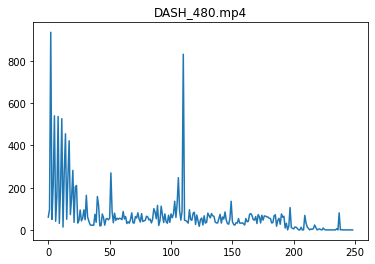

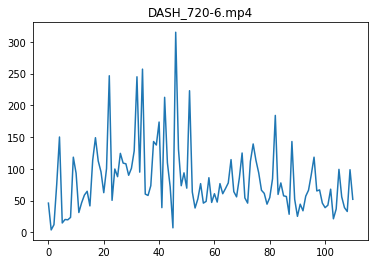

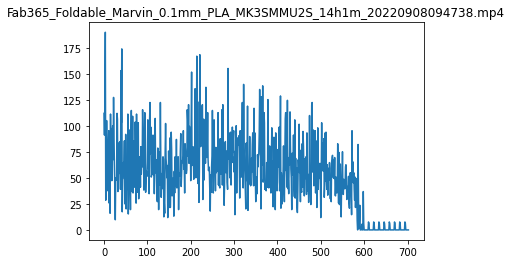

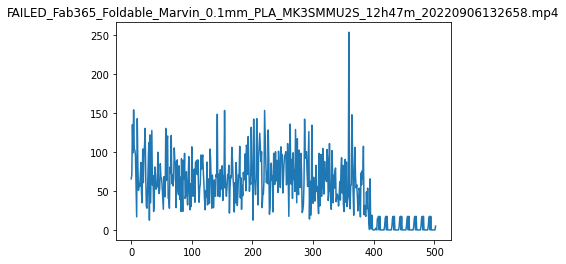

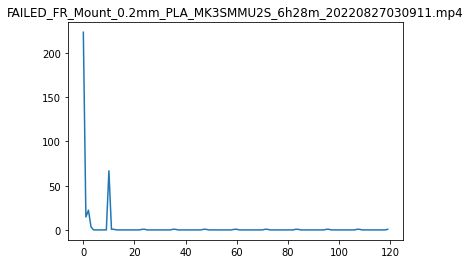

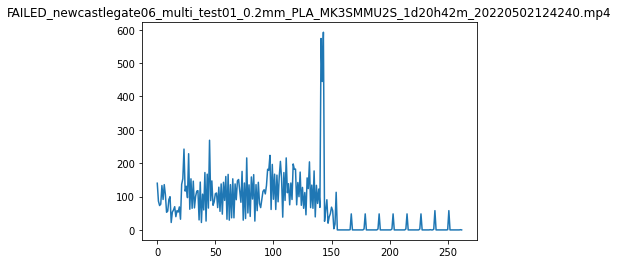

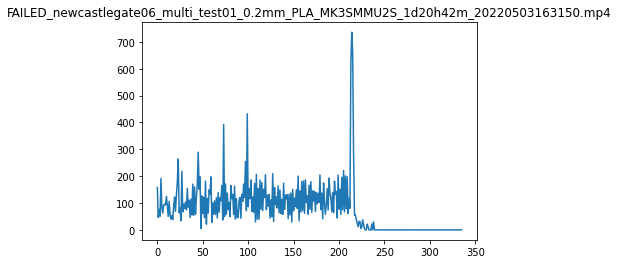

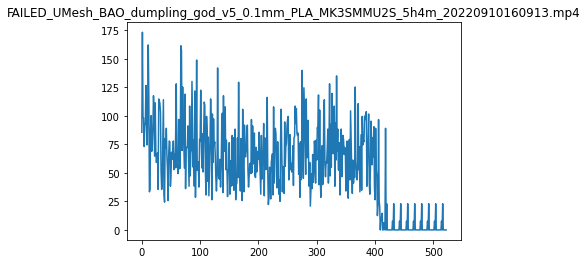

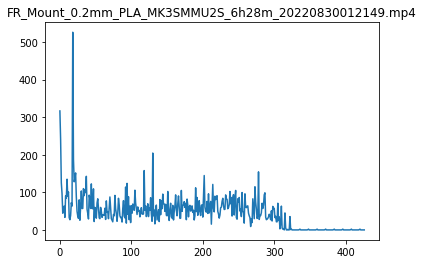

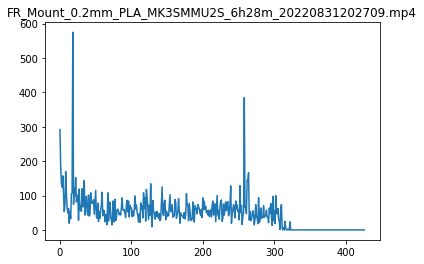

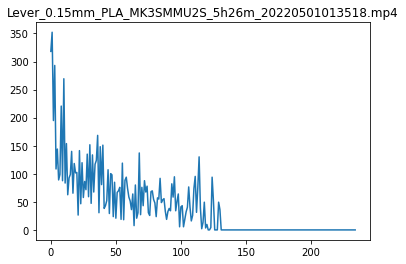

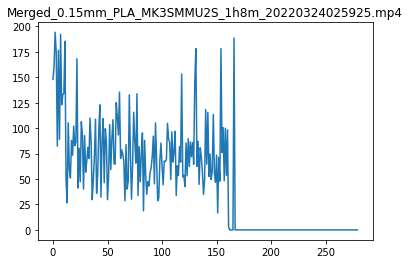

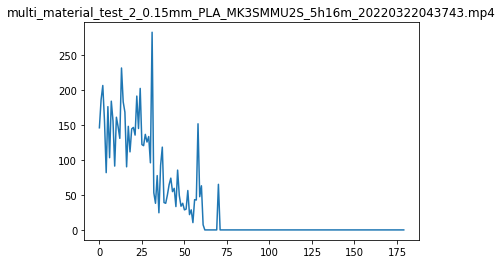

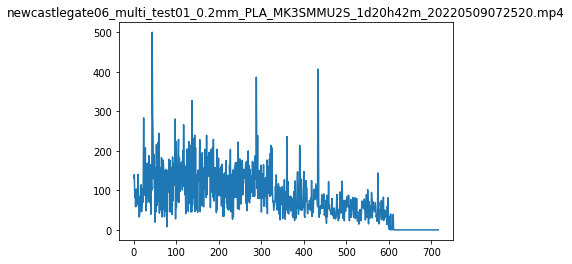

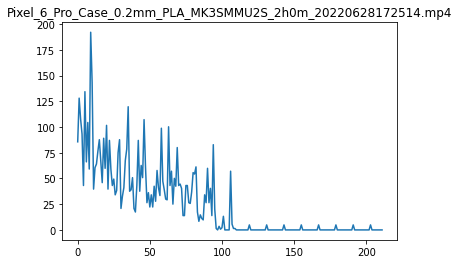

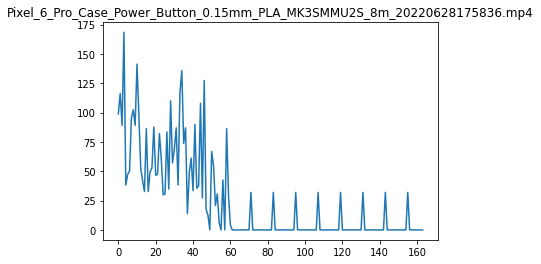

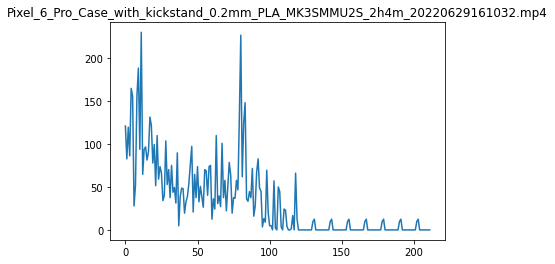

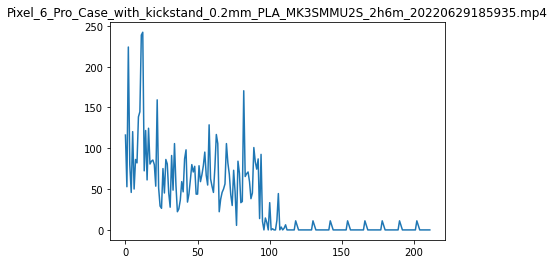

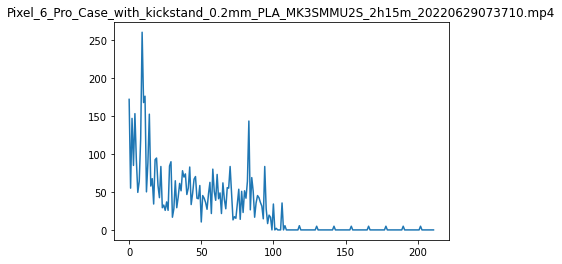

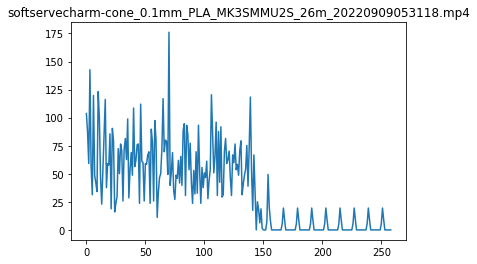

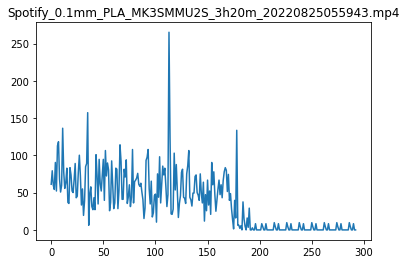

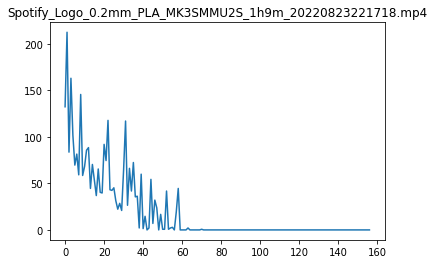

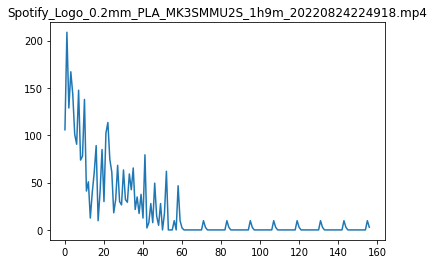

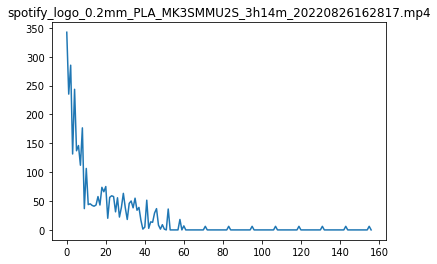

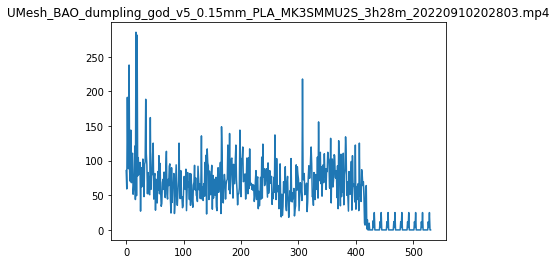

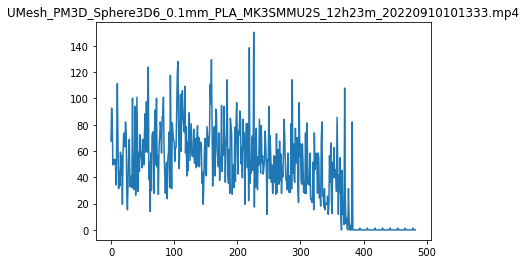

In [88]:
labels = pd.read_csv(f'{path_prefix}/labels.csv')
labels.rename(columns={'Video Name': 'filename', 'Starting frame #': 'frame_start', 'First failed frame': 'frame_failure'}, inplace=True)
for index, row in labels[labels['frame_start'] > 2].iterrows():
  edge_diff_arr = detect(url=f"{path_prefix}/{row['filename']}", initial_layer_frame = row['frame_start'], debug=False)
  plt.plot(edge_diff_arr)
  plt.title(row['filename'])
  plt.show()

In [87]:
labels[labels['frame_start'] > 2]

,filename,Video ID,Failure?,frame_start,frame_failure,Comments,Failure reason
0,DASH_480.mp4,1.0,FALSE,62.0,NaN,NaN,NaN
7,DASH_720-6.mp4,8.0,FALSE,7.0,NaN,NaN,NaN
9,Fab365_Foldable_Marvin_0.1mm_PLA_MK3SMMU2S_14h...,10.0,FALSE,121.0,NaN,NaN,NaN
10,FAILED_Fab365_Foldable_Marvin_0.1mm_PLA_MK3SMM...,11.0,TRUE,121.0,481.0,NaN,Part of figure cracked and changed it position.
11,FAILED_FR_Mount_0.2mm_PLA_MK3SMMU2S_6h28m_2022...,12.0,TRUE,121.0,122.0,NaN,A new unexpected appendix appeared
12,FAILED_newcastlegate06_multi_test01_0.2mm_PLA_...,13.0,TRUE,121.0,263.0,NaN,Figure unexpectedly rotates and ruines next pr...
13,FAILED_newcastlegate06_multi_test01_0.2mm_PLA_...,14.0,TRUE,121.0,336.0,NaN,Figure unexpectedly rotates and ruines next pr...
14,FAILED_UMesh_BAO_dumpling_god_v5_0.1mm_PLA_MK3...,15.0,?,121.0,160.0,No obvious signs that figure failed. It may be...,NaN
30,FR_Mount_0.2mm_PLA_MK3SMMU2S_6h28m_20220830012...,30.0,FALSE,121.0,NaN,NaN,NaN
31,FR_Mount_0.2mm_PLA_MK3SMMU2S_6h28m_20220831202...,31.0,FALSE,121.0,NaN,NaN,NaN
